In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import sklearn
print(sklearn.__version__)

0.23.2


In [2]:
### Read all the domcuments artribute types as required ###
### Change File Location as needed ###
CS_DS = pd.read_csv("C:/Users/USER/5. SCG/preML_v5b_010622.csv",
                     dtype={"tax_id": str, "cust_name": str,"mind_sect": str, "input1_tax_id": str
                            #"max_overdue_days": float,                          
                           })

In [ ]:
CS_DS.head()

In [ ]:
### Drop Columns that won't be used in machine learning algorithm ###
CS_DS2 = CS_DS.drop(columns=['tax_id','cust_name','mind_sect','input1_tax_id','class_max'])
CS_DS2

In [5]:
### Data Profile for Input Data ###
pd.set_option('display.max_columns', None)
pd.set_option('float_format', '{:f}'.format)
describer = CS_DS2.describe(percentiles = [.5]).T
list1 = np.count_nonzero(CS_DS2, axis=0).tolist()
describer['non_zeros'] = list1
describer['Name'] = describer.index

describer = describer[['Name','count','mean','std','min','50%','max','non_zeros']]
describer

,Name,count,mean,std,min,50%,max,non_zeros
max_overdue_days,max_overdue_days,1244.000000,49.299839,107.200728,-42.000000,18.000000,2242.000000,1132
average_overdue_days,average_overdue_days,1244.000000,17.753079,75.354339,0.000000,5.600000,2232.200000,1111
overdue_payments,overdue_payments,1244.000000,96.551447,525.799406,0.000000,11.000000,13366.000000,1111
total_payments,total_payments,1244.000000,910.383441,2114.060288,1.000000,150.500000,30352.000000,1244
before_due_bucket,before_due_bucket,1244.000000,32.491961,189.192383,0.000000,1.000000,3466.000000,779
...,...,...,...,...,...,...,...,...
OD_outstanding_std,OD_outstanding_std,1244.000000,1612062.842366,6341953.682936,0.000000,0.000000,64454129.840000,214
OD_utilize_max,OD_utilize_max,1244.000000,0.126141,0.300820,0.000000,0.000000,1.621627,238
OD_utilize_mean,OD_utilize_mean,1244.000000,0.101097,0.256194,0.000000,0.000000,1.008004,238
OD_utilize_std,OD_utilize_std,1244.000000,0.018720,0.058092,0.000000,0.000000,0.475033,214


## Modeling

In [6]:
### Cross-Validation [Stratified K-Fold] ###
from statistics import mean, stdev
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
### Separate Data into inputs vs desired output
#X = CS_DS2.iloc[:, 0:122].values
#y = CS_DS2.iloc[:, 122].values
X = CS_DS2.drop(['class_max_binary'], axis = 'columns').values #Train set
y = CS_DS2.class_max_binary.values#Test set
#X
#y

#### Random forest

##### 1. Create df of Input&Target,combined tgt
##### 2. Train_test split & Assign input to x, target to y, test_size = testing set; 0.2 for ex. proportion
- x_train, x_test; is "inputs" or all the attributes, associated with target
- y_train, y_test; is "target"/ "Desired output" or label good or bad

##### 3. from sklearn.ensenble import RandomForestClassifier
- model = RandomForestClassifier(n_estimators=20) // can changes the n_estimatior/ no. of trees
- model.fit(x_train,y_train)
- model.score(x_test,y_test)

##### 4. y_predicted = model.predict(x_test) on looking for assing the model perfomance
- from sklearn.metrics import confusion_metrix
- cm = confusion_metrix(y_test,y_predicted)
- cm //can use seaborn for better visualization

In [7]:
### Default Random Forest Settings
RF_model = RandomForestClassifier()
### USE PARAMETERS FROM RANDOMSEARCH HERE
#RF_model = RandomForestClassifier(n_estimators=300,
    #min_samples_split=5,min_samples_leaf=5,max_features='sqrt',max_depth=40,bootstrap=True)

### Split input and output into training and hidden(testing) data
X_train, X_hidden, y_train, y_hidden = train_test_split(X, y, stratify=y, test_size=0.15,random_state=0)
#print(X_train.shape, X_hidden.shape)
#print(y_train.shape, y_hidden.shape)

#### StratifiedKFold - Cross validation

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score

### Manual stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=10)
lst_B_accu_stratified = []
lst_accu_stratified = []

for train_index, test_index in skf.split(X_train, y_train):
    x_train_fold, x_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    
    RF_model.fit(x_train_fold, y_train_fold) 
    #Without Kfold, will be RF_model.fit(X_train, y_train)
    y_pred_fold = RF_model.predict(x_test_fold)
    
    lst_accu_stratified.append(accuracy_score(y_test_fold, y_pred_fold))
    lst_B_accu_stratified.append(balanced_accuracy_score(y_test_fold,y_pred_fold))

### Cross-Validation Evaluation [Evaluated against validation sets not hidden set]     
print('\nMaximum Balanced Accuracy That can be obtained from this model is:',
      max(lst_B_accu_stratified)*100, '%')
print('\nMinimum Balanced Accuracy:',
      min(lst_B_accu_stratified)*100, '%')
print('\nOverall Balanced Accuracy:',
      mean(lst_B_accu_stratified)*100, '%')
print('==================================')
print('Length Check')
print('full_data',len(X),len(y))
print('training',len(X_train),len(y_train))
print('Hidden',len(X_hidden),len(y_hidden))
print('folds','train',len(x_train_fold),len(y_train_fold),'test',len(x_test_fold),len(y_test_fold))


Maximum Balanced Accuracy That can be obtained from this model is: 84.18894830659536 %

Minimum Balanced Accuracy: 63.39285714285714 %

Overall Balanced Accuracy: 75.03452380952382 %
Length Check
full_data 1244 1244
training 1057 1057
Hidden 187 187
folds train 952 952 test 105 105


## Model Evaluations
- Confusion matrix
- accuracy score
- ROC
- Precision_Recall

In [9]:
### Model Evaluation [Evaluated against Hidden Test Set / test set {Unseen Data}] ###
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score)
from sklearn.metrics import (roc_auc_score, plot_roc_curve, roc_curve, precision_recall_curve,plot_precision_recall_curve,average_precision_score, 
                             PrecisionRecallDisplay)

y_pred_train = RF_model.predict(X_train)
y_pred_hidden = RF_model.predict(X_hidden)

print("==== TRAINING ====")
print(confusion_matrix(y_train,y_pred_train))
print(classification_report(y_train,y_pred_train))
print("balanced accuracy:",balanced_accuracy_score(y_train,y_pred_train))

print("\n==== HIDDEN ====\n")
print(confusion_matrix(y_hidden,y_pred_hidden))
print(classification_report(y_hidden,y_pred_hidden))
print("Balanced Accuracy:",balanced_accuracy_score(y_hidden,y_pred_hidden))

print("ROC AUC Score:",roc_auc_score(y_hidden,RF_model.predict_proba(X_hidden)[:, 1]))

print("Average Precision Score:",average_precision_score(y_hidden,RF_model.predict_proba(X_hidden)[:, 1]))

==== TRAINING ====
[[487  16]
 [ 12 542]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       503
           1       0.97      0.98      0.97       554

    accuracy                           0.97      1057
   macro avg       0.97      0.97      0.97      1057
weighted avg       0.97      0.97      0.97      1057

balanced accuracy: 0.9732651025256405

==== HIDDEN ====

[[65 24]
 [27 71]]
              precision    recall  f1-score   support

           0       0.71      0.73      0.72        89
           1       0.75      0.72      0.74        98

    accuracy                           0.73       187
   macro avg       0.73      0.73      0.73       187
weighted avg       0.73      0.73      0.73       187

Balanced Accuracy: 0.7274134372850264
ROC AUC Score: 0.7913322632423756
Average Precision Score: 0.7958314740824217


## Feature Importance

Text(0.5, 1.0, 'Feature Importance (MDI)')

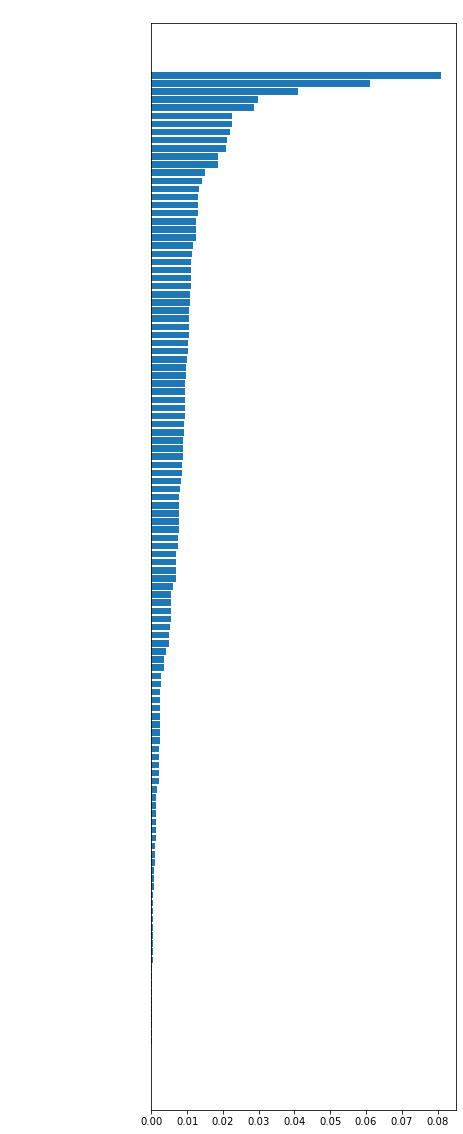

In [10]:
### Feature Importance Asessment [from Random Forest]
feature_importance= RF_model.feature_importances_
#feature_importance= grid_RF_test.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 20))
feature_names = CS_DS2.columns.tolist()

### Change plot settings as required ###
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.tick_params(axis='y', colors='white')
plt.title("Feature Importance (MDI)", color = 'white')
#sorted_idx
#feature_names

## Hyper parameter selection

In [11]:
#### HYPER PARAMETER SELECTION [Randomized CV Search] ####
def param(score_type):
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.metrics import roc_auc_score
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    #n_estimators = [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 120, num = 12)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 3, 4, 5, 6, 7, 8, 9, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 3, 4, 5, 6]
    # Method of selecting samples for training each tree
    bootstrap = [True]
    #bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    print(random_grid)

    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    #RF_Model
    # Random search of parameters, using 3 fold cross validation or change to desried k value, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = RF_model, scoring =score_type, 
                param_distributions = random_grid, n_iter = 100, cv = 3, 
                verbose=2, random_state=42, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(X_train, y_train)

    print(score_type,"\n",rf_random.best_params_)
    best_random = rf_random.best_estimator_
    print("ROC AUC Score:",roc_auc_score(y_hidden,rf_random.predict_proba(X_hidden)[:, 1]))
    print("ROC AUC Score:",roc_auc_score(y_hidden,best_random.predict_proba(X_hidden)[:, 1]))

#param('balanced_accuracy')
param('roc_auc')
#param('average_precision')

### SEE IF ROC_AUC SCORE HAS IMPROVED OR NOT ###

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, None], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_leaf': [1, 2, 3, 4, 5, 6], 'bootstrap': [True]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   47.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.0min finished


roc_auc 
 {'n_estimators': 400, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True}
ROC AUC Score: 0.7901857372162349
ROC AUC Score: 0.7901857372162349


In [12]:
### MODEL EVALUATION OF Settings from Randomized Search ###

### USE PARAMETERS FROM RANDOMSEARCH HERE
RF_model2 = RandomForestClassifier(n_estimators=400,
                                  min_samples_split=6,
                                  min_samples_leaf=4,
                                  max_features='auto',
                                  max_depth=110,
                                  bootstrap=True)

from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                             balanced_accuracy_score)
from sklearn.metrics import (roc_auc_score, plot_roc_curve, roc_curve, precision_recall_curve, 
                             plot_precision_recall_curve,average_precision_score, 
                             PrecisionRecallDisplay)

RF_model2.fit(X_train, y_train)
y_pred_train = RF_model2.predict(X_train)
y_pred_hidden = RF_model2.predict(X_hidden)

print("==== TRAINING ====")
print(confusion_matrix(y_train,y_pred_train))
print(classification_report(y_train,y_pred_train))
print("balanced accuracy:",balanced_accuracy_score(y_train,y_pred_train))
print("\n==== HIDDEN ====\n")
print(confusion_matrix(y_hidden,y_pred_hidden))
print(classification_report(y_hidden,y_pred_hidden))
print("Balanced Accuracy:",balanced_accuracy_score(y_hidden,y_pred_hidden))
print("ROC AUC Score:",roc_auc_score(y_hidden,RF_model2.predict_proba(X_hidden)[:, 1]))
print("Average Precision Score:",average_precision_score(y_hidden,RF_model2.predict_proba(X_hidden)[:, 1]))


==== TRAINING ====
[[466  37]
 [ 37 517]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       503
           1       0.93      0.93      0.93       554

    accuracy                           0.93      1057
   macro avg       0.93      0.93      0.93      1057
weighted avg       0.93      0.93      0.93      1057

balanced accuracy: 0.9298271741392798

==== HIDDEN ====

[[67 22]
 [28 70]]
              precision    recall  f1-score   support

           0       0.71      0.75      0.73        89
           1       0.76      0.71      0.74        98

    accuracy                           0.73       187
   macro avg       0.73      0.73      0.73       187
weighted avg       0.73      0.73      0.73       187

Balanced Accuracy: 0.7335473515248796
ROC AUC Score: 0.7897271268057785
Average Precision Score: 0.7961881206144512
